# DS 7331 - Machine Learning - Course Project
Team: Allison Roderick, Jayson Barker, Sandesh Ojha, Brandon Croom

Lab Number: 2

## Data Preparation - 15pts
The following cells setup the notebook for use and analysis

In [3]:
# Import libraries for data analysis
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display,HTML
from sklearn import ensemble
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn import tree, metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from IPython.display import Image  
from sklearn.ensemble import AdaBoostRegressor
import pydotplus
warnings.simplefilter('ignore')

# show all columns
pd.set_option('display.max_columns', None) 

#Set the seaborn plotting style
sns.set(style="darkgrid")

## Continuous Decision Tree

In [10]:
#Read in the train/test files that have been created from the prior projects. This is an 80/20 split
train_file = 'train.csv'
test_file = 'test.csv'
test_filepath_BC = ''
train_filepath_BC = ''
test_filepath_BC2 = ''
train_filepath_BC2 = ''

testfilepath_AR = ''
train_filepath_AR = ''

test_filepath_JB = 'F:/SMU/DS7331/Train_Test_Files/'
train_filepath_JB = 'F:/SMU/DS7331/Train_Test_Files/'

test_filepath_SO = ''
train_filepath_SO = ''

df_test = pd.read_csv(test_filepath_JB + test_file,index_col=0)
df_train = pd.read_csv(train_filepath_JB + train_file,index_col=0)

# Round the distance to one decimal place
df_train = df_train.round({'Distance(mi)': 1})

# Filter data set for TX records
df_train = df_train[df_train['State'] == 'TX']

#### In this cell, the data set is split into test, train, and the test and train continuous predictors (in this case, Distance(mi)).

In [12]:
# Get validation set off of last 20% of train data
df_train=df_train.sort_values("Start_Time")
train_size = int(len(df_train) * 0.8)
X_train, X_val = df_train[0:train_size], df_train[train_size:len(df_train)]
y = df_train['Distance(mi)']
y_train, y_val = y[0:train_size], y[train_size:len(y)]

#Build training/validation set for distance
df_X_train = X_train.copy()
df_X_test = X_val.copy()
df_Y_train = y_train.copy()
df_Y_test = y_val.copy()

#list columns to remove:
removeList = {'Distance(mi)','Weather_Condition','SM_Interim','State','Timezone','Start_Time','TMC_200.0',
              'TMC_201.0','TMC_202.0','TMC_203.0',
              'TMC_206.0','TMC_222.0','TMC_229.0',
              'TMC_236.0','TMC_239.0','TMC_241.0',
              'TMC_244.0','TMC_245.0','TMC_246.0',
              'TMC_247.0','TMC_248.0','TMC_336.0',
              'TMC_339.0','TMC_341.0','TMC_343.0',
              'TMC_351.0','TMC_406.0','ST_AL','ST_AR','ST_AZ','ST_CA','ST_CO','ST_CT','ST_DC','ST_DE',
              'ST_FL','ST_GA','ST_IA','ST_ID','ST_IL','ST_IN','ST_KS','ST_KY','ST_LA','ST_MA','ST_MD',
              'ST_ME','ST_MI','ST_MN','ST_MO','ST_MS','ST_MT','ST_NC','ST_ND','ST_NE','ST_NH','ST_NJ',
              'ST_NM','ST_NV','ST_NY','ST_OH','ST_OK','ST_OR','ST_PA','ST_RI','ST_SC','ST_SD','ST_TN',
              'ST_TX','ST_UT','ST_VA','ST_VT','ST_WA','ST_WI','ST_WV','ST_WY'} 
df_X_train.drop(removeList,1,inplace=True)
df_X_test.drop(removeList,1,inplace=True)

In [13]:
#Convert dataframes to numpy arrays
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
Y_train = df_Y_train.to_numpy()
Y_test = df_Y_test.to_numpy()

print("X-train: ",df_X_train.shape)
print("X-test: ",df_X_test.shape)
print("Y-train: ",df_Y_train.shape)
print("Y-test: ",df_Y_test.shape)

X-train:  (163692, 73)
X-test:  (40923, 73)
Y-train:  (163692,)
Y-test:  (40923,)


#### In this cell, the test and train features are standardized

In [14]:
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set

#### In this cell, the decision tree is constructed and iterated through to identify the depth that produces the best R2 score. It's important to note that we've tuned the tree to use a min_split that produces the best R2 score without being too small of a value to cause overfitting. We also use the train data set here as a comparative to refer back to as the tree iterates.

In [15]:
r2_results=[]
train_r2_results=[]

MSE_results=[]
train_MSE_results=[]

MAE_results=[]
train_MAE_results=[]

max_depths = np.arange(2,60,step=2)

for max_depth in max_depths:
    
    min_split = math.ceil(len(X_train_scaled) * .001)
    #min_split = 2

    clf = tree.DecisionTreeRegressor(criterion='mse', max_depth=max_depth, 
                                    min_samples_split=min_split, min_samples_leaf=2, 
                                    max_features=20,
                                    max_leaf_nodes=None,
                                    random_state=123)
    
    # fit - training
    clf = clf.fit(X_train_scaled, Y_train)

    
    # build yhat using the train features to test accuracy metrics
    yhat = clf.predict(X_test_scaled)
    train_yhat = clf.predict(X_train_scaled)

    # MAE - higher = worse performing | lower = better
    predict_mae = mean_absolute_error(Y_test, yhat)
    train_mae = mean_absolute_error(Y_train, train_yhat)

    # MSE - higher = worse performing | lower = better
    predict_mse = mean_squared_error(Y_test, yhat)  
    train_mse = mean_squared_error(Y_train, train_yhat)

    # r2 score
    predict_score2 = mt.r2_score(Y_test, yhat)
    train_score2 = mt.r2_score(Y_train, train_yhat)


    # graphing variables
    r2_results.append(predict_score2)
    train_r2_results.append(train_score2)
    
    MSE_results.append(predict_mse)
    train_MSE_results.append(train_mse)
    
    MAE_results.append(predict_mae)
    train_MAE_results.append(train_mae)

    # depth of tree
    depth = clf.get_depth()
    leaves = clf.get_n_leaves()
    
    print ('--------------------------------------')
    print ('Tree depth:', depth)
    print ('Tree leaves:', leaves)
    print ('-------')
    print ('TEST')
    print ('Mean average error (test):', predict_mae)
    print ('Mean squared error (test):', predict_mse)
    print ('R2 score (test):', predict_score2)
    print ('-------')
    print ('TRAIN')
    print ('Mean average error (train):', train_mae)
    print ('Mean squared error (train):', train_mse)
    print ('R2 score (train):', train_score2)
    print ('--------------------------------------')

--------------------------------------
Tree depth: 2
Tree leaves: 4
-------
TEST
Mean average error (test): 0.09311797745644314
Mean squared error (test): 0.7141961548028364
R2 score (test): -0.07037717234090213
-------
TRAIN
Mean average error (train): 0.07459249879752854
Mean squared error (train): 0.314615227507044
R2 score (train): 0.016423338639321883
--------------------------------------
--------------------------------------
Tree depth: 4
Tree leaves: 11
-------
TEST
Mean average error (test): 0.09146700681853119
Mean squared error (test): 0.7133338574082906
R2 score (test): -0.06908483347757444
-------
TRAIN
Mean average error (train): 0.07430625502994367
Mean squared error (train): 0.3141473298358048
R2 score (train): 0.017886119805327394
--------------------------------------
--------------------------------------
Tree depth: 6
Tree leaves: 29
-------
TEST
Mean average error (test): 0.1602318529270728
Mean squared error (test): 1.3652001981390014
R2 score (test): -1.04604731

--------------------------------------
Tree depth: 39
Tree leaves: 1619
-------
TEST
Mean average error (test): 0.14997344400252216
Mean squared error (test): 0.8781741696764329
R2 score (test): -0.3161336395329284
-------
TRAIN
Mean average error (train): 0.06351334712070576
Mean squared error (train): 0.2769399211892528
R2 score (train): 0.1342070590823008
--------------------------------------
--------------------------------------
Tree depth: 39
Tree leaves: 1619
-------
TEST
Mean average error (test): 0.14997344400252216
Mean squared error (test): 0.8781741696764329
R2 score (test): -0.3161336395329284
-------
TRAIN
Mean average error (train): 0.06351334712070576
Mean squared error (train): 0.2769399211892528
R2 score (train): 0.1342070590823008
--------------------------------------
--------------------------------------
Tree depth: 39
Tree leaves: 1619
-------
TEST
Mean average error (test): 0.14997344400252216
Mean squared error (test): 0.8781741696764329
R2 score (test): -0.31

#### From the iterated results, a series of visualizations is produced to evaluate the various metrics we've identified to evaluate the effectiveness of the model (and to identify the ideal tree depth). The metrics visualized below include: 1) R2, 2) MSE, and 3) MAE

#### The results from the R2 metric are low, across both the test and train data sets. We suspect this may be due in part to outliers in the data. Evaluating the MAE and MSE metrics will be revealing.

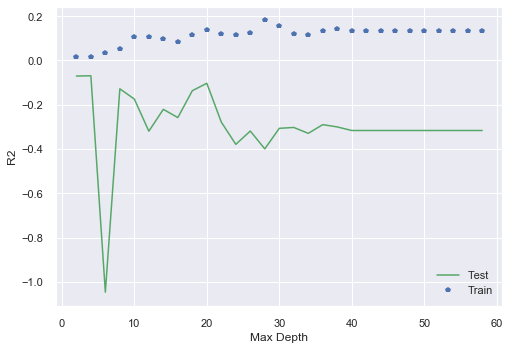

In [16]:
plt.plot(max_depths, r2_results, 'g', label="Test")
plt.plot(max_depths, train_r2_results, 'p', label="Train")

plt.legend()
plt.ylabel("R2")
plt.xlabel("Max Depth")
plt.show()

#### The results from the MSE metric for the train set are lower than the test set, but not by a substantial margin. Seeing as how both the test and train scores are relatively close, this is a good indicator that the model is performing equally well on both data sets.

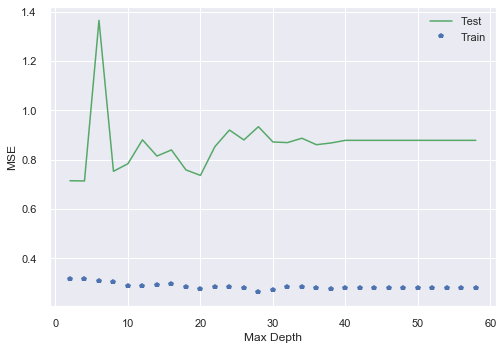

In [17]:
plt.plot(max_depths, MSE_results, 'g', label="Test")
plt.plot(max_depths, train_MSE_results, 'p', label="Train")

plt.legend()
plt.ylabel("MSE")
plt.xlabel("Max Depth")
plt.show()

#### The MAE plot indicates that the model is accurate to within about 0.10 - 0.18 of a mile of the distance of the extent and effect of the accident. This is also relatively close to the distance predicated using the train data set indicating the model is performing about equally well between the two data sets. Moreover, comparing MSE to MAE, we can see a wide differential between the two values. This further illustrates that there is likely an influence of outliers within the data sets. We will explore this via box plots below.

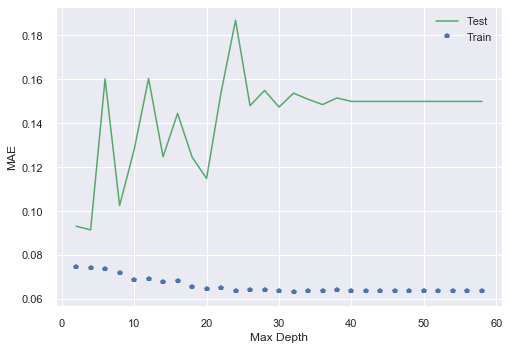

In [21]:
plt.plot(max_depths, MAE_results, 'g', label="Test")
plt.plot(max_depths, train_MAE_results, 'p', label="Train")

plt.legend()
plt.ylabel("MAE")
plt.xlabel("Max Depth")
plt.show()

#### Boxplot for yhat which are the predicted test values for distance compared to the actual y test values (second box plot below). We can see that there are subtantially larger outliers in the y Test target variable compared to the predicted values using the train data set explaining why the R2 score is likely not the best measure of the effectiveness of this model.

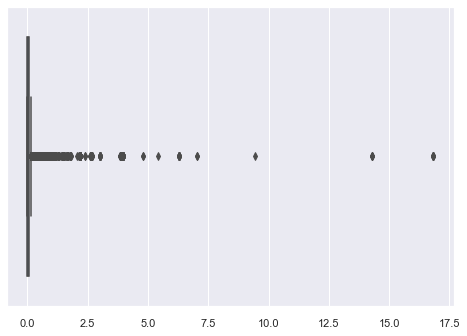

In [22]:
ax = sns.boxplot(yhat)

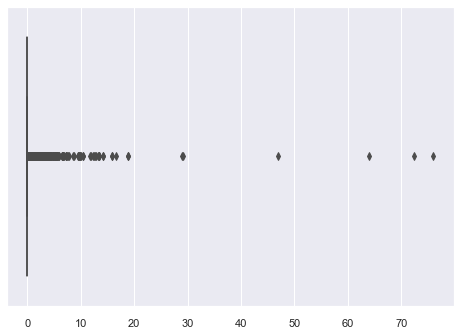

In [23]:
ax = sns.boxplot(x=Y_test)

#### Conclusion: the depth that produces the highest R2 score and lowest MAE is a tree depth of 10 with 156 leaves. Evaluating the MAE score indicates that our model can predict the length of the road extent affected by the accident within an accuracy of approximately 0.10 - 0.18 miles generally. Outliers of course may result in wildly different distances but across most accidents (at least modelled from this data set), the extent of the affect is predicted within less than 1/4 of a mile. This may be useful for first responders and others trying to get to the scene quickly since they can anticipate the potential affect on traffic that the accident might cause.

## Modeling and Evaluation - 70pts

### Categorical Variable Modeling

In [5]:
#Convert dataframes to numpy arrays

X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()

Y_train = df_Y_train.to_numpy()
Y_test = df_Y_test.to_numpy()

In [30]:
print("X-train: ",X_train.shape)
print("X-test: ",X_test.shape)
print("Y-train: ",Y_train.shape)
print("Y-test: ",Y_test.shape)

X-train:  (1760176, 143)
X-test:  (440044, 143)
Y-train:  (1760176,)
Y-test:  (440044,)


### Logistic Regression Model

In [6]:
#logistic regression - Severity
%time
logistic_regression= LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear')
logistic_regression.fit(X_train,Y_train)
Y_pred=logistic_regression.predict(X_test)

Wall time: 5.99 ms


In [7]:
# Accuracy | Accuracy = (TP+TN)/Total
print(mt.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82    309416
         1.0       0.57      0.53      0.55    130628

    accuracy                           0.74    440044
   macro avg       0.69      0.68      0.69    440044
weighted avg       0.74      0.74      0.74    440044



### SVM Model

In [8]:
#NOTE: Code below adapted from the course lectures
# we want to normalize the features based upon the mean and standard deviation of each column. 

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set 

In [10]:
%%time
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', shuffle=True)

svm_sgd.fit(X_train_scaled,Y_train)
yhat = svm_sgd.predict(X_test_scaled)
    
conf = mt.confusion_matrix(Y_test,yhat)
acc = mt.accuracy_score(Y_test,yhat)

print('SVM:', acc)

SVM: 0.738455699884557
Wall time: 15.6 s


### Categorical Variable Modeling

In [11]:
#build two training/test sets for distance
#Build the Distance dataframes
df_X_train = df_train.copy()
df_X_test = df_test.copy()


df_Y_train = df_X_train['Distance(mi)'].copy()
df_Y_test = df_X_test['Distance(mi)'].copy()

#list columns to remove:
removeList = {'Distance(mi)', 'Weather_Condition','SM_Interim','State','Timezone','Start_Time','Unnamed: 0'} 

df_X_train.drop(removeList,1,inplace=True)
df_X_test.drop(removeList,1,inplace=True)

In [12]:
#Convert dataframes to numpy arrays
X_train = df_X_train.values
X_test = df_X_test.values

Y_train = df_Y_train.values
Y_test = df_Y_test.values

In [ ]:
### SVM Model

In [13]:
#NOTE: Code below adapted from the course lectures
# we want to normalize the features based upon the mean and standard deviation of each column. 

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set 

In [14]:
%%time
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', shuffle=True)

svm_sgd.fit(X_train_scaled,Y_train)
yhat = svm_sgd.predict(X_test_scaled)
    
conf = mt.confusion_matrix(Y_test,yhat)
acc = mt.accuracy_score(Y_test,yhat)

print('SVM:', acc)

ValueError: Unknown label type: (array([0.00000000e+00, 9.99999978e-03, 1.00000000e-02, ...,
       2.27210007e+02, 2.54399994e+02, 3.33630005e+02]),)

## Model Deployment - 5pts

## Exceptional Work - 10pts